In [1]:
from pathlib import Path
from pprint import pprint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8')
plt.rcParams['legend.framealpha'] = 1  ## disable any default legend frame transparency from the style

---
---
# [1] Analyze Each Carr-Purcell Sequence

In [18]:
def plot_purcell(
    fpath           : Path,
    find_peak_params: dict         = ...,  ## default is {'distance': 100, 'height': 1}
    cols            : tuple[int]   = [3,4],
    curve_fit_guess : tuple[float] = (10, 0.01, 1),
    idx_peaks2skip  : tuple[int]   = [],
    # title           : str          = '',
    tmin            : float        = None,  ## units of ms
    tmax            : float        = None,
    ax              : plt.Axes     = None,
) -> dict[str, float | str]:

    # if title:
    #     print(f'Analyzing {title}...')
    # else:
    #     print(f'Analyzing {fpath.name}...')



    # --------------------------------- load data -------------------------------- #
    df = pd.read_csv(
        fpath,
        usecols = cols,
        header = None,
        names = ['t', 'v'],
    )



    # ------------------------------- crop & scale ------------------------------- #

    # df['t'] *= meta['x_scale']
    # df['v'] *= meta['y_scale']

    # df = df[
    #     (df['t'] > meta['x_bounds'][0]) &
    #     (df['t'] < meta['x_bounds'][1])
    # ]

    if tmin is not None:
        df = df[df['t'] > tmin * 1e-3]
    if tmax is not None:
        df = df[df['t'] < tmax * 1e-3]



    # ---------------- convert to 1D numpy arrays for convenience ---------------- #
    dat_t = df['t'].to_numpy()
    dat_v = df['v'].to_numpy()



    # -------------------------------- find peaks -------------------------------- #

    default = {'distance': 50, 'height': 1}

    if find_peak_params is ...:
        find_peak_params = {}

    ## merge default and user-provided parameters, with user-provided taking precedence
    find_peak_params = {
        **default,
        **find_peak_params,
    }



    idx_peaks = find_peaks(
        dat_v,
        **find_peak_params,
    )[0]

    idx_peaks = np.delete(idx_peaks, idx_peaks2skip)

    dat_t_peaks = dat_t[idx_peaks]
    dat_v_peaks = dat_v[idx_peaks]



    # ------------------------------------ fit ----------------------------------- #
    def exp_decay(t, A, B, C):
        return A * np.exp(-t/B) + C

    popt, pcov = curve_fit(
        exp_decay,
        dat_t_peaks,
        dat_v_peaks,
        p0 = curve_fit_guess,
    )
    A_fit, B_fit, C_fit = popt
    # print(f'    - Fit: (A, B, C) = ({A_fit:.3f}, {B_fit:.3e}, {C_fit:.3f})')
    # print(f'    - T_2 = {B_fit * 1e3 :.2f} ms')


    dat_t_fit = np.linspace(
        dat_t_peaks.min(),
        dat_t_peaks.max(),
        1000,
    )
    dat_v_fit = exp_decay(dat_t_fit, A_fit, B_fit, C_fit)



    # ----------------------------------- plot ----------------------------------- #

    # fig, ax = plt.subplots(figsize=(8, 6))
    own_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        own_fig = True

    ax.plot(
        dat_t * 1e3,
        dat_v,
        label = 'Raw Data',
        # alpha = 0.5,
        linewidth = 1,
    )

    ax.scatter(
        dat_t_peaks * 1e3,
        dat_v_peaks,
        label = f'Echo Peaks (Total {len(idx_peaks)})',
        color = 'firebrick',
        s = 10,
    )

    ax.plot(
        dat_t_fit * 1e3,
        dat_v_fit,
        # 'k-',
        label = (
            r'Decay Envelope: $A \cdot \exp (-t/B) + C$'
            # f'\n$\\Longrightarrow$A={A_fit:.2f}, B={B_fit:.2e}, C={C_fit:.2f}',
            f'\n$ \\Longrightarrow (A,B,C)=$({A_fit:.2f}, {B_fit:.2e}, {C_fit:.2f})'
        ),
        linestyle = 'dashed',
    )

    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Voltage [V]')
    # ax.set_title(title)




    t_max = dat_t_peaks.max()
    t_min = dat_t_peaks.min()
    t_diff = t_max - t_min
    padding = 0.1
    ax.set_xlim(
        (t_min - padding*t_diff) * 1e3,
        (t_max + padding*t_diff) * 1e3,
    )




    ax.set_title(
        r'$N = $'
        f'{len(idx_peaks)}, '
        r'$\tau = $'
        f'{t_diff * 1e3 :.0f} ms'
    )




    legend = ax.legend(
        # loc='lower left',
        frameon=True,
    )
    frame = legend.get_frame()
    frame.set_alpha(None)  ## disable any rcParam alpha override
    frame.set_facecolor((1, 1, 1, 0.1))  ## set frame coloring to white with some transparency
    frame.set_edgecolor('black')

    # plt.show()
    if own_fig:
        plt.show()

    return {
        'T2 [ms]': B_fit * 1e3,
        'Num Peaks': len(idx_peaks),
        'Total Time [ms]': t_max - t_min,
    }

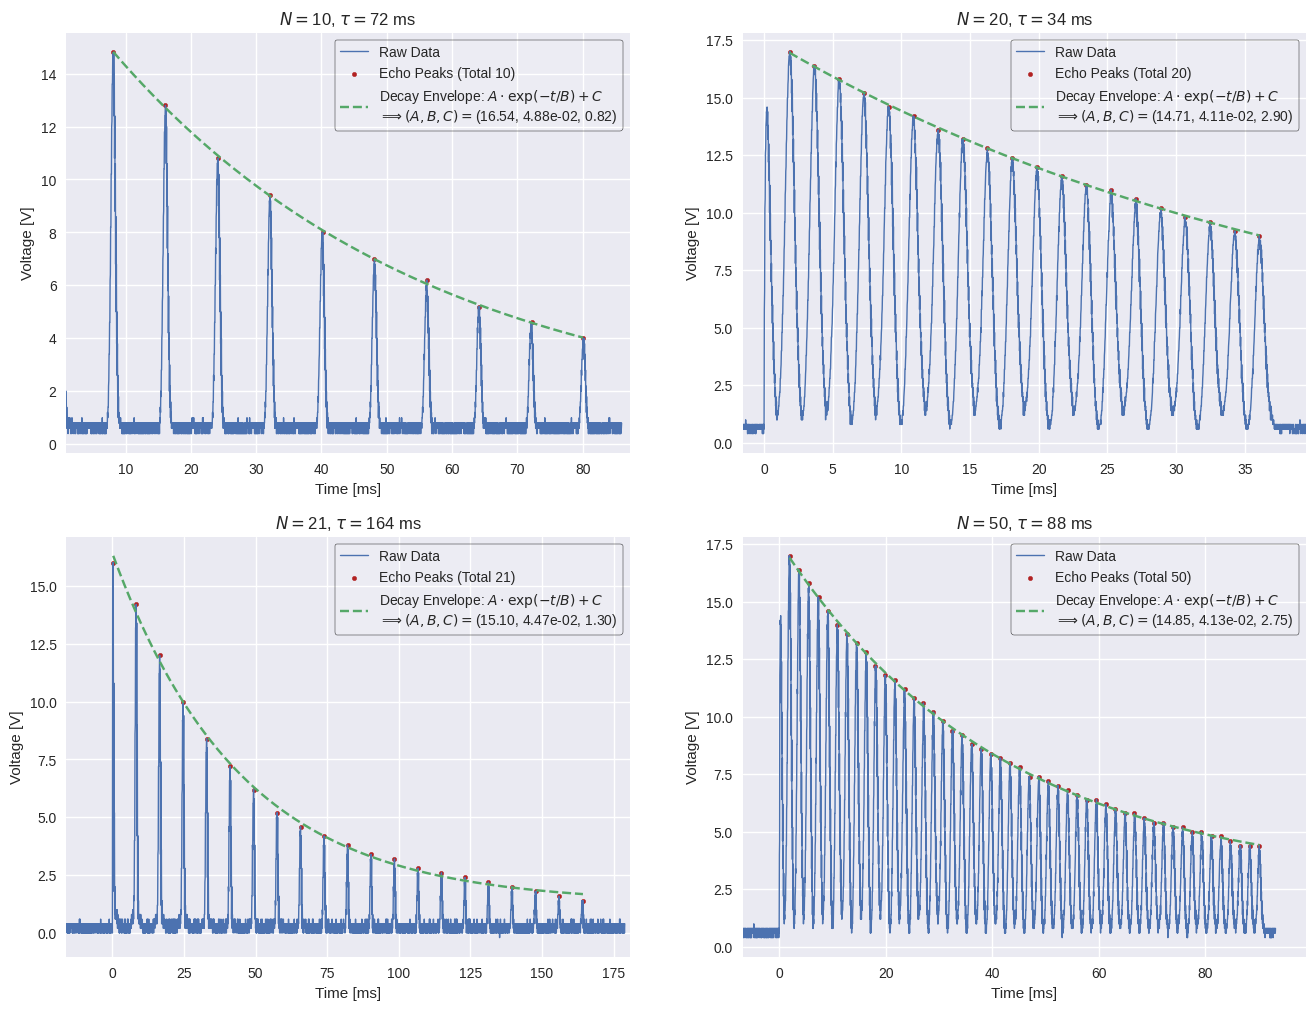

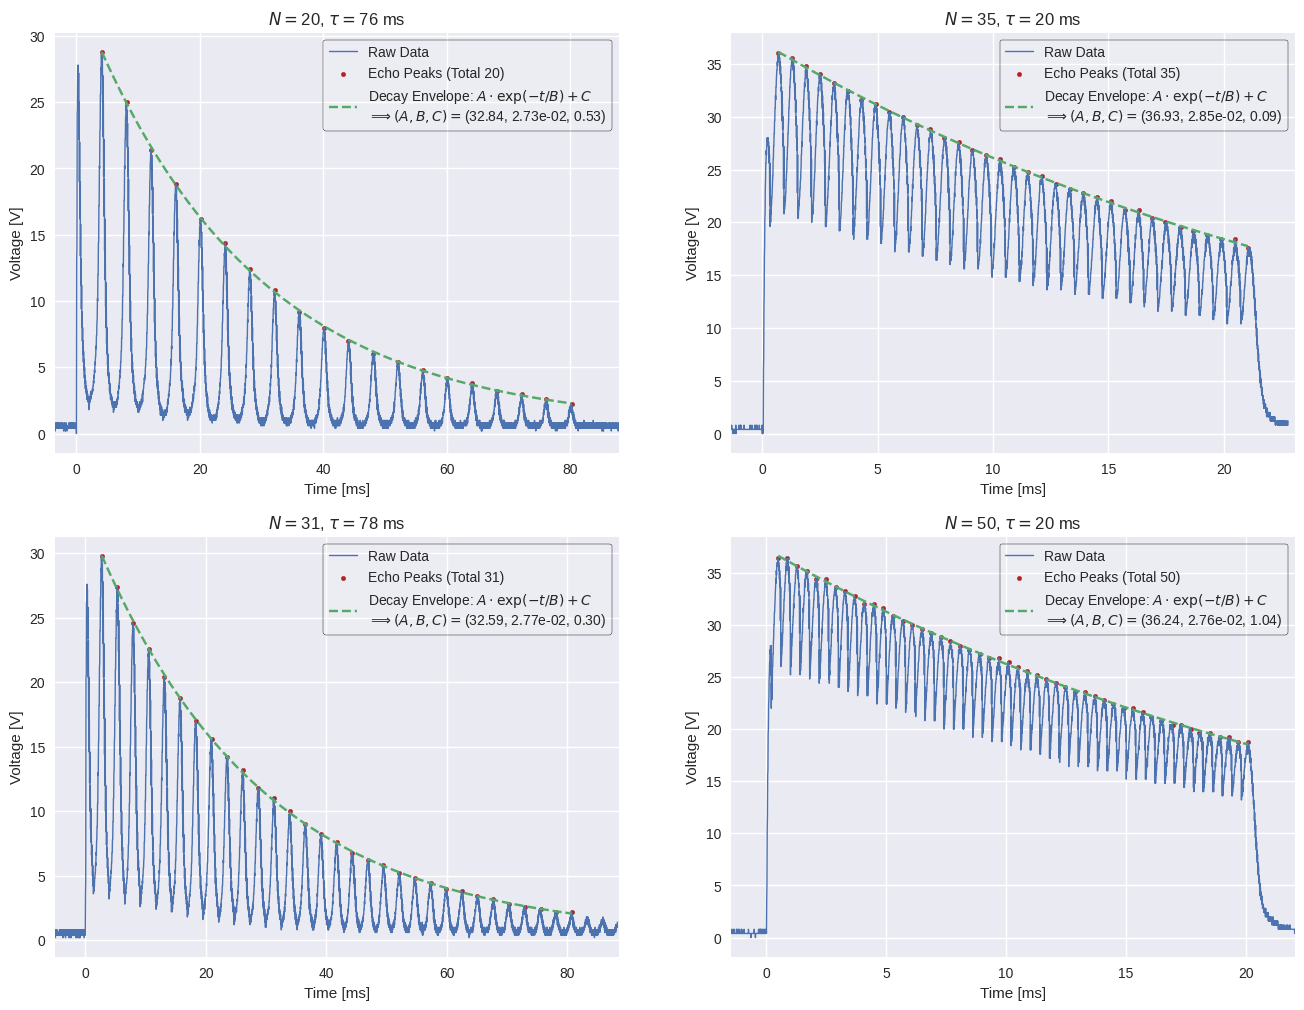

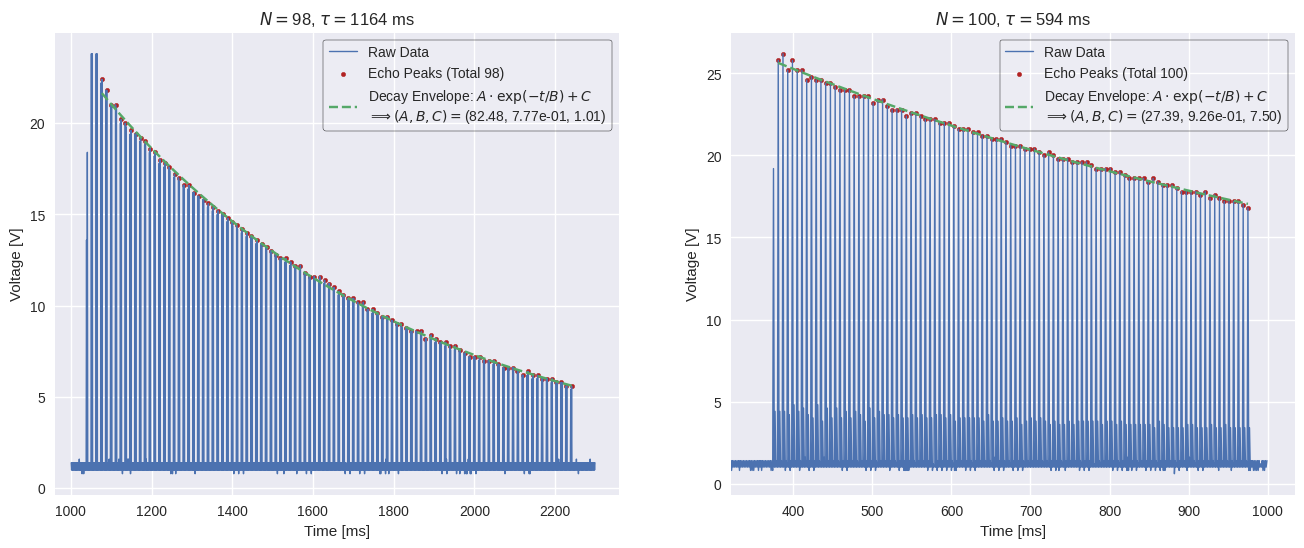

In [19]:
# -------------------------------- user input -------------------------------- #

## SPECIFY THIS FOR YOUR OWN COMPUTER!!!
dirpath_repo = Path('/home/lain/root/100_work/110_projects/111_mars/code-repos/redplanet/scrap/nmr/')



# ------------------------------- dataset info ------------------------------- #

dirpath_data = dirpath_repo / 'nmr/nmr_data/purcell/'

metadata = {
    'mineral_oil': {
        'n-10-tau-4ms.csv': {
            'find_peak_params': {
                'height': 3,
            },
            'idx_peaks2skip': [0],
        },
        'n-20-tau-1ms.csv': {
            'find_peak_params': {
                'height': 3,
            },
            'idx_peaks2skip': [0],
        },
        'carr-purcell-sequence-2.csv': {
            'cols': [9, 10],
        },
        'n-50-tau-900us.csv': {
            'find_peak_params': {
                'height': 3,
                'distance': 25,
            },
            'idx_peaks2skip': [0],
        },
    },
    'glycerin': {
        'n-20-tau-2ms.csv' : {
            'find_peak_params': {
                'height': 2,
                'distance': 75,
            },
            'idx_peaks2skip': [0],
            'curve_fit_guess': (30, 0.02, 10),
        },
        'n-35-tau-0.3ms.csv': {
            'find_peak_params': {
                'height': 15,
                'distance': 35,
            },
            'idx_peaks2skip': [0],
        },
        'n-40-tau-1.3ms.csv' : {
            'find_peak_params': {
                'height': 1,
            },
            'idx_peaks2skip': [0, -3, -2, -1],
            'curve_fit_guess': (30, 0.02, 10),
        },
        # 'n-40-tau-1ms.csv': {},
        'n-50-tau-0.2ms.csv': {
            'find_peak_params': {
                'height': 15,
                'distance': 25,
            },
            'idx_peaks2skip': [0],
        },
    },
    'water': {
        'n-100-tau-6ms.csv': {
            'find_peak_params': {
                'height': 5,
                'distance': 10,
            },
            'curve_fit_guess': (10, 1, 1),
            'cols': [9, 10],
            'idx_peaks2skip': [0, 1, 2],
            'tmin': 1000,
            'tmax': 2300,
        },
        'n-100-tau-3ms.csv': {
            'find_peak_params': {
                'height': 15,
                'distance': 5,
            },
            'curve_fit_guess': (10, 1, 1),
            'cols': [9, 10],
            'idx_peaks2skip': [0],
            'tmin': 250,
            'tmax': 1000,
        },
    },
}



# --------------------------------- plot all --------------------------------- #

# results = []

# for dirname_compound in metadata:

#     compound_name = dirname_compound.replace('_', ' ').title()

#     print()
#     print('-' * 80)
#     print(compound_name)
#     print('-' * 80)
#     print()

#     for fname, plotting_params in metadata[dirname_compound].items():

#         fpath = dirpath_data / dirname_compound / fname
#         title = compound_name + f'\n({fname})'

#         this_results = plot_purcell(
#             fpath,
#             **plotting_params,
#             title=title,
#         )

#         this_results['Compound'] = compound_name
#         results.append(this_results)

#         pprint(this_results)
#         print()

import math

for compound, files in metadata.items():
    compound_name = compound.replace('_', ' ').title()
    fnames = list(files.items())
    n = len(fnames)
    rows = math.ceil(n / 2)

    fig, axes = plt.subplots(
        rows, 2,
        figsize=(8*2, 6*rows),
        squeeze=False
    )
    axes_flat = axes.flatten()

    for i, (fname, params) in enumerate(fnames):
        ax = axes_flat[i]
        # title = f"{compound_name}\n({fname})"
        # title = f"({fname})"
        # title = f'({compound}__{fname})'
        plot_purcell(
            dirpath_data / compound / fname,
            **params,
            # title=title,
            ax=ax
        )

    # hide any extra subplots
    for j in range(n, rows*2):
        fig.delaxes(axes_flat[j])

    # fig.suptitle(compound_name, fontsize=16)
    # fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


---
---
# [2] Overall Results

In [4]:
df_results = pd.DataFrame(results)
df_results

,T2 [ms],Num Peaks,Total Time [ms],Compound
0,48.790781,10,0.07192,Mineral Oil
1,41.090311,20,0.03420,Mineral Oil
2,44.699536,21,0.16400,Mineral Oil
3,41.330686,50,0.08816,Mineral Oil
4,27.340260,20,0.07608,Glycerin
5,28.512200,35,0.02036,Glycerin
6,27.723445,31,0.07800,Glycerin
7,27.566879,50,0.01958,Glycerin
8,777.211748,98,1.16400,Water
9,925.563850,100,0.59400,Water


In [5]:
df_results.groupby('Compound').agg(
    {
        'T2 [ms]': ['mean', 'std'],
    }
).reset_index()

Compound     T2 [ms]            
                      mean         std
0     Glycerin   27.785696    0.509240
1  Mineral Oil   43.977829    3.606961
2        Water  851.387799  104.900777

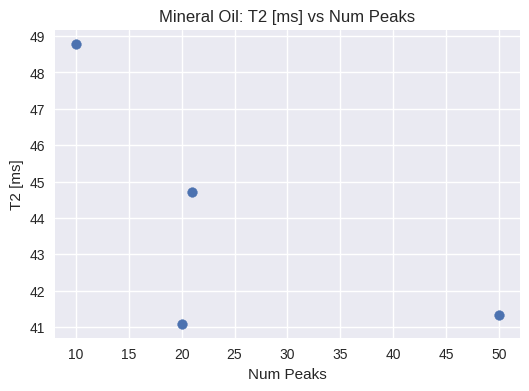

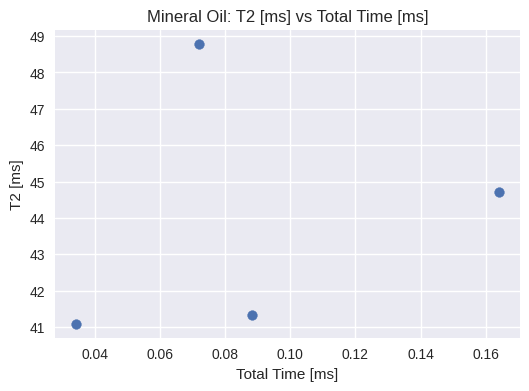

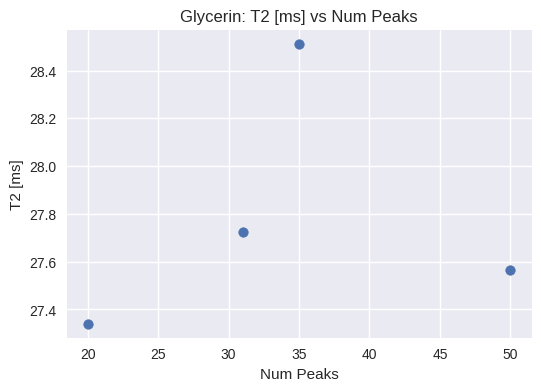

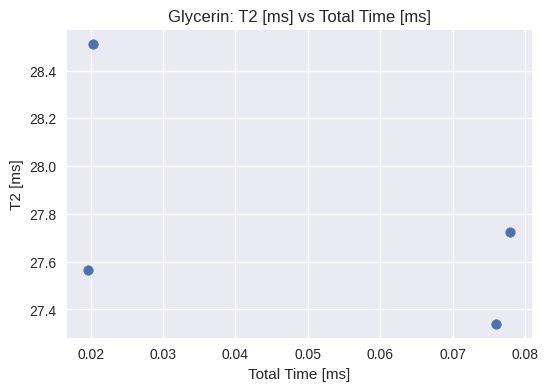

In [6]:
# Filter data for each compound
mineral = df_results[df_results['Compound'] == 'Mineral Oil']
glycerin = df_results[df_results['Compound'] == 'Glycerin']

# --- Mineral Oil Plots ---

# Plot 1: T2 [ms] vs Num Peaks for Mineral Oil
plt.figure(figsize=(6, 4))
plt.scatter(mineral['Num Peaks'], mineral['T2 [ms]'])
plt.xlabel('Num Peaks')
plt.ylabel('T2 [ms]')
plt.title('Mineral Oil: T2 [ms] vs Num Peaks')
plt.show()

# Plot 2: T2 [ms] vs Total Time [ms] for Mineral Oil
plt.figure(figsize=(6, 4))
plt.scatter(mineral['Total Time [ms]'], mineral['T2 [ms]'])
plt.xlabel('Total Time [ms]')
plt.ylabel('T2 [ms]')
plt.title('Mineral Oil: T2 [ms] vs Total Time [ms]')
plt.show()

# --- Glycerin Plots ---

# Plot 3: T2 [ms] vs Num Peaks for Glycerin
plt.figure(figsize=(6, 4))
plt.scatter(glycerin['Num Peaks'], glycerin['T2 [ms]'])
plt.xlabel('Num Peaks')
plt.ylabel('T2 [ms]')
plt.title('Glycerin: T2 [ms] vs Num Peaks')
plt.show()

# Plot 4: T2 [ms] vs Total Time [ms] for Glycerin
plt.figure(figsize=(6, 4))
plt.scatter(glycerin['Total Time [ms]'], glycerin['T2 [ms]'])
plt.xlabel('Total Time [ms]')
plt.ylabel('T2 [ms]')
plt.title('Glycerin: T2 [ms] vs Total Time [ms]')
plt.show()
